In [1]:
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import functools

%matplotlib inline


# Bayes Rule
 - Reverend Thomas Bayes
 - To infers existence of God
 - Holy Grail of Probabilistic thinking
 - Informed Artificial Intelligence


In [2]:
def cancer_test():
    """
    :returns: P(C|P);
    Prob you have cancer given the test is positive
    Solution: https://www.udacity.com/course/viewer#!/c-st101/l-48703346/e-48759018/m-48480554
    
    """
    #returning this suggests your chances of having cancer
    #Haven't changed regardless of the test returning positive
    p_c = 0.01 
    
    #Returning this is an answer to a different question;
    #this is the probability of positive test result
    #This question asks about the probability of cancer
    p_p_g_c = 0.9
    
    p_c_g_p = 0.08
    
    #Since sensitivity (i.e. the amount of confidence we can put)
    #That a positive test means a positive cancer?
    #Is high; we expect it increases our chances from the generic population
    assert p_c_g_p > p_c
    
    #And no relation to p_p_g_c; different question
    
    return p_c_g_p
    

# Sensitivity vs Specificity 

 - **Sensitivity**
  - Chances the outcome (i.e. have disease) is predicted by the indicator (i.e. a test says you have disease) 
  - the amount of confidence we can have in this test
 - **Specificity**
  - Chances the lack of outcome (i.e. no disease) is predicted by indicator (i.e. a test says you dont have disease)
 
 If we are conservative, (in medicine we are) then... 
  - we are willing to say we have cancer even if we dont (fail sensitivity test)
  - and we really want to be sure that a negative test, can be reliable (pass specificity test)
 



In [3]:
class Event(object):
    
    GIVEN = ' given '
    NOT = 'not'
    AND = ' and '
    NEGATIVE = 'negative'
    POSITIVE = 'positive'
    
    #def __new__(cls, name, prob, prob_universeprob_population={}):
    #    return super().__new__(cls, name, prob, prob_population)
    # Was gonna check first the population, but...
    
    def __init__(self, name):#, *args, **kwargs):
        self.__name = str(name).strip()
        
    def __neg__(self):
        return self.__invert__()
    
    def __invert__(self):
        """
        The idea of a binary event
        :returns: the 'inverse' of this event; this event not-happening
        """
        # A conditional event; just negate the posterior
        if self.given():
            return (~self.posterior()) | self.given()
        
        # A joint event; negate both and re-join
        if all(self.joint()):
            return ~self.joint()[0]  & ~self.joint()[1]
        
        # A negative single event; make positive
        if self.__name.startswith(self.NOT):
            return Event(self.__name.lstrip(self.NOT).strip('()'))
            
        # A positive single event; make negative
        else:
            #if self.POSITIVE in self.__name:
            #    not_name = self.__name.replace(self.POSITIVE, self.NEGATIVE)
            #elif self.NEGATIVE in self.__name:
            #    not_name = self.__name.replace(self.NEGATIVE, self.POSITIVE)
            #else:
            return Event('{0}({1})'.format(self.NOT, self.__name))
        
    def __or__(self, event_2):
        """Notice this would *not* support
        transitive property as "or" normally should
        Though I guess "truthied" things aren't actually transitive
        (A__or__B == B__or__A)
        """
        return self.given(event_2)
    
    def __and__(self, event_2):
        """
        """
        return self.joint(event_2)
    
    def joint(self, event_2=None):
        """
        Quiz: Prior And Posterior
        CORRECTION: From 0:45 onward, the posterior for the cancer case 
        should be written as P(C, Pos) instead of P(C|Pos), and the 
        one for the non-cancer case should read P(~C, Pos) instead 
        of P(~C|Pos).
        
        there is a correction to when
        consider that self.AND could be the *comma*, 
        https://classroom.udacity.com/courses/st101/lessons/48703346/concepts/487236370923
        """
        if event_2 is None:
            if self.AND in self.__name:
                return [Event(_) for _ in self.__name.split(self.AND)]
            else:
                return [None, None]
        else:
            and_name = '{0}{1}{2}'.format(self, self.AND, event_2)
            return Event(and_name)
        
    def alt_events(self):
        first, second = self.joint()
        other_joint = '{0}{1}{2}'.format(second, self.AND, first) 
        return [Event(_) for _ in [other_joint]]
    
    def posterior(self):
        """
        If this is a conditional,
        P(Cancer|Pos)
        :returns: the name of the posterior event, that the patient has Cancer
        """
        #GET method
        if self.GIVEN in self.__name:
            #assert self.GIVEN in self.__name, 'No second event'
            return Event(self.__name.split(self.GIVEN)[0])
        #No SET method because there is not left-to-right syntax
        #Whereas the "given" method creates a new conditional
            
            
   
    def given(self, event_2=None):
        """
        If this is a conditional, event
        P(Cancer|Pos)
        :params event_2: the second event IF you want to create a new given event
        :returns: the name of the original event, that test is Positive, if no event_2 param passed and this is a conditional event
        Else a new conditional event created by combining self and event_2
        """
        #GET method
        if event_2 is None:
            
            if self.GIVEN in self.__name:
                #assert self.GIVEN in self.__name, 'No first event'
                return Event(self.__name.split(self.GIVEN)[1])
        #SET method
        else:
            given_name = '{0}{1}{2}'.format(self, self.GIVEN, event_2)
            #given_prob = prob
            return Event(given_name) #, given_prob, self.__probs)
   
    def __nickname__(self):
        """
        Would want nicknames for like 'gay' could by 'G'
        And other  conventions (saved as constants) like 'N' for 'not'
        
        'G' for given; or the symbol '|'
        'A' for and; or the symbol or acceptable '&'
        """
        return (self.__name
                .replace(' given ', '|')
                .replace(' and ', ',')
                .upper())
        
    def __repr__(self):
        return 'Event("{}")'.format(self.__name)

    def __str__(self):
        return self.__name

    def __hash__(self):
        return hash(tuple(sorted(self.__name.split(self.AND))))

    def __eq__(self, other):
        return hash(self) == hash(other)

In [195]:
class Probability(dict):
    
    
    def __init__(self, print_log=False, *args, **kwargs):
        # https://stackoverflow.com/a/2390997/1175496
        # https://stackoverflow.com/a/2390913/1175496
        self.print_log = print_log
        self.__log__ = []
        #Allows us to say P(Event('Red')) = set('AB'), i.e. the events 'A' and 'B' map direclty to red. 
        # TODO: What does this mean about their posterior relationship? their joint relationship? 
        #{'Red' : {'A', 'B'} }
        #Then later:
        #{'Red' : {'A', 'B'} , '~Red': {'C'}}
        self.__event_set_map__ = {}
        #After above produces:
        #{
        # 'A' : 'Red',
        # 'B' : 'Red',
        # 'C': '~Red'
        #}

        self.__set_element_event_map__ = {}
        dict.__init__(self, *args, **kwargs)
        
    def __call__(self, event, *args, **kwargs):
        return self.__getitem__(event)
        
    def log(self, *stuff):
        self.__log__.append(*stuff)
        if (self.print_log):
            print(*stuff)
            
    def __getitem__(self, key):
        """
        Not a sequence type;
        Not implementing negative integers or accepting ranges
        """

        if isinstance(key, str):
            #Otherwise:
            # <ipython-input-176-625a83d6e567> in __getitem__(self, key)
            #      37         """
            #      38 
            # ---> 39         result = super().__getitem__(key)
            #      40         if  result is None:
            #      41             for alt_event in key.alt_events():

            # KeyError: 'A'
            key = Event(key)
            
        result = super().__getitem__(key)
        if  result is None:
            for alt_event in key.alt_events():
                result = super().__getitem__(alt_event)
                if result:
                    break
                    
        return result
    
    def __set__(self, event, prob):
       
        assert event is not None, 'Event must be not None'
            
        prob = float(prob)
        event = Event(event)
        
        #NOTE: prob *can be 0*, and prob *can also be 1!
        #Dont think of it as contiguous ranges; remember Probabilities add to 1!
        #So prob of 0 and prob of 1 must co-exist!
        assert 0 <= prob <= 1, 'Dont know probability of {0} ' \
        '{1} outside of limits 0 and 1'.format(event, prob) 
        
        #If already set, dont continue
        #Ah, but it could be zero!
        
        if self.get(event) is not None:
            return 
        
        self.log('setting event "{}" to prob {}'.format(event, prob))
        
        try:
            if np.isclose(prob, 0): #prob===0:
                self.log('the value is 0!')
            super().__setitem__(event, prob)
        except Exception as e:
            self.log('Some error dont want it to bubble past me recursively')
            self.log(e)
        
        #Create Joint from Conditional and Single matching Original Event
        #=================
        #Scenario 1; event = P(A|B) and already have P(B)
        #Can create P(A&B)
        
        
        try:
            conditional_event = event
            conditional_prob = prob
            
            given_event = event.given()
            # print(given_event)
            given_event_prob = self[given_event]
            #Now set the probability (in the entire event space) 
            #of *both* the conditional event, and also the joint event; P(A&B):
            #Who is the P(B) * P(A|B)
            joint_event = conditional_event.posterior() & conditional_event.given()
            joint_prob = conditional_prob * given_event_prob
            
            #print('joint', joint_event, joint_prob)
            self.__set__(joint_event, joint_prob)
            
            #Create not from conditional
            #=================
            #Scenario 1a; event = P(A|B) 
            # Can create P(~A|B)
            not_posterior_same_given = ~conditional_event.posterior()  | given_event
            not_posterior_same_given_prob = 1 - prob
            self.__set__(not_posterior_same_given, not_posterior_same_given_prob)
            
            
            
        except KeyError as e:
            msg = 'dont have Probability for Event "{}"'.format(given_event) if given_event is not None else 'no event.given()'
            self.log('No joint, {}'.format(msg))
            
        #Create Joint from Single and any matching Conditional
        #================
        #Scenario 2; event = P(B) and already have P(N|B); 
        #    notice how "N" could be anything! Could be more than one; for-loop it
        #Can create P(N&B)
        try:
            original_prob = prob
            original_event = event
            conditional_events = [_ for _ in self.events() if _.given()==original_event]
            #[0]
  
            for conditional_event in conditional_events:
                conditional_prob = self[conditional_event]
                
                joint_event = conditional_event.posterior() & conditional_event.given()
                joint_prob = conditional_prob * original_prob
                
                # print('joint', joint_event, joint_prob)
                self.__set__(joint_event, joint_prob)
            
        #Exception expected from the list accessing first element: [0]
        #except IndexError as e:
        #It *was* error accessing first element, but I'm no longer doing that, I'm iterating
        #And if there is no first element, that means I won't iterate! 
        #Is that "graceful degradation" or not?
        except Exception as e:
            self.log(e)
            #print(e)
            pass#print('No joint, dont have events with original {}'.format(original_event))#pass#print('No scenario 2')
            
        #Create Joint from Single and any matching Conditional
        #================
        #Scenario 2; event = P(B) and already have P(N&B) or P(B&N)
        #    notice how "N" could be anything! Could be more than one; for-loop it
        #Can create P(N|B)
        try:
            original_prob = prob
            original_event = event
            import pdb
            #if str(original_event)=='positive':
            #    pdb.set_trace()
            joint_events = [_ for _ in self.events() if original_event in _.joint()]#[0]
  
            for joint_event in joint_events:
                joint_prob = self[joint_event]
                other_event = [_ for _ in joint_event.joint() if _ !=original_event][0]
                
                conditional_event = other_event | original_event
                conditional_prob = joint_prob / original_prob
                
                #print('jointtt')
                self.__set__(conditional_event, conditional_prob)
            
        except Exception as e:
            print(e)
            
        
        #Create Single from Joint and other Single in Joint
        #====================
        #Scenario one; event = P(A&B) and ...
        #we have P(A) so we can create P(A|B) 
        #or we have P(B) and we can create P(B|A)
        e_1, e_2 = event.joint() 
        joint_event = event
        joint_prob = prob
        for original_event, second_event in ((e_1, e_2), (e_2, e_1)):
            try:
                original_prob = self[original_event]
                
                conditional_event = second_event | original_event
                conditional_event_prob = joint_prob / original_prob
                
                #print('conditional')
                self.__set__(conditional_event, conditional_event_prob)

            except Exception as e:
                pass#print('No conditional')#pass
            
            #Create Single from Joint and other Single in Joint
            #====================
            #Scenario one; event = P(A&B) and ...
            #we have P(A&~B) so we can create P(A) 
            #or we have P(B&~A) and we can create P(B)
            #And if we can do those, we have to put them back through this method, right?
            try:
                original_and_not_second_prob = self[original_event & ~second_event]
                
                full_original_event = original_event
                full_original_event_prob = joint_prob + original_and_not_second_prob
                
                #print('conditional')
                #print('full', full_original_event)
                self.__set__(full_original_event, full_original_event_prob)

            except Exception as e:
                if original_event and second_event:
                    pass# print(e)

    def events(self):
        return self.keys()
    
    
    def __setitem__(self, event, prob):
        #IF we have P(A) we can get P(~A),
        #And if the not would produce any other effects, we should follow those through
        
        if isinstance(prob, set):
            original_set = prob
            self.__event_set_map__[event] = original_set
            for set_element in original_set:
                
                self.__set_element_event_map__[set_element] = event
            
            complement_set = self.__event_set_map__.get(~event)
            
            if complement_set is not None:
                
                    assert len(original_set & complement_set)==0, 'The sets contain duplicate elements!'
                    #Take the union ; 
                    #Somehow we gotta know the total_set, the Event itself should be aware of that somehow.
                    #It doesnt meant ht eevent is aware of all other events,
                    #But at least that a P can know if they have all of em... Hmm...
                    #So we can sum up to 1, or do posterior vs joints...
                    total_set =  original_set | complement_set
                    
                    #First set the probabilities of each
                    for set_element in total_set:
                        #This supposes they are equally weighted, 
                        #But this is not always true!
                        #Sebastians case he was able to give us P[A] = P[B] = P[C] = 1/3
                        #But couldve done: P[A] = 1/2; P[B] = P[C] = 1/4
                        #Only if these havent been set already . Great, if they are set already, then this will be ignored
                        #Goes down to __set__, which ignores values if already set.
                        self.__setitem__(set_element, 1/len(total_set))
                        
                    #Then set the individual probabilities of the events they map to
                    #The complement will be taken care of by the (event, prob) , (~event, 1-prob) seen below...
                    original_prob = len(original_set)/len(total_set)
                    #this will trigger the numeric version
                    self.__setitem__(event, original_prob)
                    
                    
        else:
            if isinstance(event, str):
                #Otherwise:
                # --> 243             for event, prob in ((event, prob), (~event, 1-prob)):
                #     244                 #print(event, prob)
                #     245                 self.__set__(event, prob)

                # TypeError: bad operand type for unary ~: 'str'
                event = Event(event)
            #both the event and its complementary:
            #complement is always in a special domain: The event or not the event.
            #But the event may exist as part of a larger set; i.e. A, of { A, B, C}
            #The ~event is called the complement; the 1-prob is called the "inverse" ???
            
            #https://classroom.udacity.com/courses/st101/lessons/48729374/concepts/486889570923
            for event, prob in ((event, prob), (~event, 1-prob)):
                #print(event, prob)
                self.__set__(event, prob)
        
    def venn(self, event1, event2, round_to=4):
        # P, C, Pos = cancer_test()
        # #Remember the order:
        # #                 Ab          aB        AB
        # subsets =     (P(C&~Pos),  P(~C&Pos),  P(C&Pos))

        # #Round it otherwise  the labels look bad:
        # subsets = list(round(_, 4) for _ in subsets)
        # venn2(subsets=subsets)
        #TODO: I think this entire Probability class may only work if there are 2 distinct events (each of which comes with its "not Event happens" equivalent; so 4 things total)
        #And manipulating the size of those 3 spaces, the 3 subsets, as far as the venn diagram is concerned
        #But 4 spaces, when we know the 2 circles / 3 spaces are relative to a bounding box, we can size the bounding box.
        
        from matplotlib_venn import venn3, venn2
        subsets =     (self[event1&~event2],  P[~event1&event2],  P[event1&event2])
        subsets = list(round(_, round_to) for _ in subsets)
        return venn2(subsets)

In [108]:

P = Probability()
C = Event('cancer')
Pos = Event('positive') 
Neg = ~Pos
p_g_c=Pos | C
#print(p_g_c)
#print(p_g_c.given())
#print(p_g_c.posterior())
#print(Pos | None)

def cancer_test():
    """
    The question being asked is this: 1% of the population has cancer. 
    Given that there is a 90% chance that you will test positive if you 
    have cancer and that there is a 90% chance you will test negative 
    if you don't have cancer, what is the probability that you have 
    cancer if you test positive?
    """

    P = Probability()
    C = Event('cancer')
    Pos = Event('positive') 
    
    P[C] = 0.01
    P[Pos | C] = 0.9
    P[~Pos | ~C] = 0.9

    return P, C, Pos
          
P, C, Pos = cancer_test()

# print(P(C | Pos))
# print(P(~C | Pos))
# print(P(C & Pos))
# print(P(Pos & C))
# print(P(~C & Pos))
# print(P(Pos & ~C))
print(P[~C])
print(P[~Pos|C])
print(P[Pos|~C])

None
No joint, no event.given()
None
No joint, no event.given()
cancer
joint positive and cancer 0.009000000000000001
None
No joint, no event.given()
cancer
joint not(positive) and cancer 0.0009999999999999998
None
No joint, no event.given()
not(cancer)
joint not(positive) and not(cancer) 0.891
None
No joint, no event.given()
None
No joint, no event.given()
not(positive)
joint cancer and not(positive) 0.0009999999999999998
not(positive)
joint not(cancer) and not(positive) 0.891
not(cancer)
joint positive and not(cancer) 0.09899999999999998
None
No joint, no event.given()
None
No joint, no event.given()
positive
joint cancer and positive 0.009000000000000001
positive
joint not(cancer) and positive 0.09899999999999998
0.99
0.09999999999999998
0.09999999999999998


In [25]:

P, C, Pos = cancer_test()
print(P(C & ~Pos))
print(P(~C & ~Pos))

0.0009999999999999998
0.891


In [27]:

P, C, Pos = cancer_test()
print(P(~Pos))

0.892


In [29]:

P, C, Pos = cancer_test()
print(P(C|~Pos))
print(P(~C|~Pos))

0.0011210762331838563
0.9988789237668162


In [32]:

P, C, Pos = cancer_test()
print(P(C))
print(P(C|~Pos))
print('So our cancer probability went down by about a factor of 9')
print(P(C)/P(C|~Pos))

0.01
0.0011210762331838563
So our cancer probability went down by about a factor of 9
8.920000000000002


In [37]:

P, C, Pos = cancer_test()
print(P(~C))
print(P(~C|~Pos))
print('So our not-having-cancer probability went up by a very small number, (factor of 1.00896? = 0.8% increase?)')
print(P(~C|~Pos)/P(~C))
# This would be the consistent operand order as the previous post, however, 
# I concluded the larger of the operands should always go first
# print(P(~C)/P(~C|~Pos))

0.99
0.9988789237668162
So our not-having-cancer probability went up by a very small number, (factor of 1.00896? = 0.8% increase?)
1.0089686098654709


In [40]:
from matplotlib_venn import venn3

ModuleNotFoundError: No module named 'matplotlib_venn'

In [44]:
!pip install matplotlib_venn

In [51]:
from matplotlib_venn import venn3, venn2

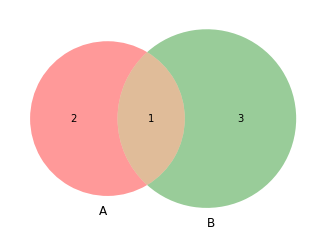

In [54]:
venn2([set(['A', 'B', 'C']), set(['A', 'D', 'E', 'F'])])

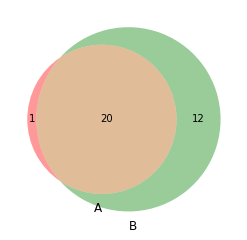

In [58]:
#Or can use a 3-element argument:
#"The functions venn2 and venn2_circles accept as their only required argument a 3-element list (Ab, aB, AB) of subset sizes, e.g.:"
# https://pypi.python.org/pypi/matplotlib-venn
venn2(subsets=(1, 12, 20))

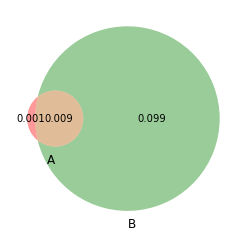

In [66]:
#The P() function above does not directly produce the crescents labeled '1' and '12' in the above case;
#In other words, the areas where circle A doesnt touch B and vice versa.
#If circle A represented cancer, and circle B represented the test is positive
#Then the crescent for A represents having cancer, but test comes back negative.
#Crescent B represents the test coming back positive, but not having cancer
#Oh... we actually do have a concept for those, right?
# (~Pos | C) test is negative given you have cancer
# (~C | Pos) dont have cancer given test is positive

#Yes but they are relative to different denominators ; 
#i.e. (~Pos | C) only tells you what proportion of Cancer 
#To get those areas relative to a common denominator, the "normalizer"

#The ones we want are:
# (~Pos & C) test is negative and you have cancer (opposite of sensitivity?)
# (~C & Pos) you dont have cancer and test is positive  (opposite of specificity?)


P, C, Pos = cancer_test()
#Remember the order:
#                 Ab          aB        AB
subsets =     (P(C&~Pos),  P(~C&Pos),  P(C&Pos))

#Round it otherwise  the labels look bad:
subsets = list(round(_, 4) for _ in subsets)
venn2(subsets=subsets)

![See the venn diagram that Sebastian drew](img/venn_diagram.png)

In [6]:
(C | Pos).joint()

[None, None]

In [7]:
(C | Pos).posterior() , (C | Pos).given()

(Event("cancer"), Event("positive"))

In [8]:
(C & Pos).joint()

[Event("cancer"), Event("positive")]

In [16]:
import pprint
pprint.pprint(list(P.items()))
print('Should have 16 long. 2 for the cancer vs ~cancer. 2 for the pos vs ~pos. 4 for the combination of "givens" in one direction, 4 for the combinations of "givens" in the other direction, and  4 for the combination of "ands" in the middle')
pprint.pprint(len(list(P.items())))

[(Event("cancer"), 0.01),
 (Event("not(cancer)"), 0.99),
 (Event("positive given cancer"), 0.9),
 (Event("positive and cancer"), 0.009000000000000001),
 (Event("not(positive) given cancer"), 0.09999999999999998),
 (Event("not(positive) and cancer"), 0.0009999999999999998),
 (Event("not(positive) given not(cancer)"), 0.9),
 (Event("not(positive) and not(cancer)"), 0.891),
 (Event("not(positive)"), 0.892),
 (Event("cancer given not(positive)"), 0.0011210762331838563),
 (Event("not(cancer) given not(positive)"), 0.9988789237668162),
 (Event("positive given not(cancer)"), 0.09999999999999998),
 (Event("positive and not(cancer)"), 0.09899999999999998),
 (Event("positive"), 0.10799999999999998),
 (Event("cancer given positive"), 0.08333333333333336),
 (Event("not(cancer) given positive"), 0.9166666666666666)]
Should have 16 long. 2 for the cancer vs ~cancer. 2 for the pos vs ~pos. 4 for the combination of "givens" in one direction, 4 for the combinations of "givens" in the other direction, a

In [14]:
0.892 + 0.107999999999999999999


1.0

In [55]:
1/6.

0.16666666666666666

In [40]:
P.keys()

dict_keys([Event("cancer"), Event("not(cancer)"), Event("positive given cancer"), Event("positive and cancer"), Event("not(positive) given cancer"), Event("not(positive) and cancer"), Event("not(positive) given not(cancer)"), Event("not(positive) and not(cancer)"), Event("positive given not(cancer)"), Event("positive and not(cancer)")])

In [236]:
'Event("cancer", 0.5)' == 'Event("cancer", 0.5)'

True

In [67]:
def normalizing_1():
    return (P(C&Pos) + P(~C&Pos))
normalizing_1()

0.10799999999999998

In [21]:
assert np.isclose(normalizing_1(), 0.108), 'Normalized sum of P(C&Pos) + P(~C&Pos) should be around 0.108'

In [68]:
def normalizing_2():
    return P(C|Pos)
normalizing_2()

0.08333333333333336

In [24]:
P(C&Pos),P(Pos)

(0.009000000000000001, 0.10799999999999998)

In [30]:
assert np.isclose(normalizing_2(), 0.0833333), 'The P(C|Pos) 0.0833, which is P(C&Pos) / P(Pos) = 0.009 / 0.108 = 0.0833 '

In [31]:
0.0833333

0.0833333

In [26]:
 0.009 / 0.108

0.08333333333333333

In [33]:
def normalizing_3():
    return P(~C|Pos)
normalizing_3()

0.9166666666666666

In [35]:
P(~C&Pos)

0.09899999999999998

In [36]:
0.09899 / 0.108

0.916574074074074

In [37]:
assert np.isclose(normalizing_3(), 0.916666), 'The P(~C|Pos) 0.9166, which is P(~C&Pos) / P(Pos) = 0.09899 / 0.108 = 0.91657'

In [39]:
def total_probability():
    return P(C|Pos) + P(~C|Pos)
total_probability()

1.0

In [40]:
assert np.isclose(total_probability(), 1.0), 'total_probability, which can only be a sum of conditional probabilities, should be 1, not {}'.format(total_probability())

![Nate added more stuff](img/diagram remade.png)

In [73]:
P=Probability()
Cancer = Event('Cancer')
Positive = Event('Positive')
P[Cancer]=0.1
P[Positive|Cancer]=0.9
P[~Positive|~Cancer]=0.5
print(P(~Cancer))
print(P(~Positive|Cancer))
print(P(Positive|~Cancer))


print(P(Cancer&~Positive))
print(P(~Cancer&~Positive))
print(P(~Positive))


print(P(Cancer|~Positive))
print(P(~Cancer|~Positive))


0.9
0.09999999999999998
0.5
0.009999999999999998
0.45
0.46
0.021739130434782605
0.9782608695652174


In [74]:

print(P(Cancer&Positive))
print(P(~Cancer&Positive))
print(P(Positive))


print(P(Cancer|Positive))
print(P(~Cancer|Positive))

0.09000000000000001
0.45
0.54
0.16666666666666669
0.8333333333333333


In [130]:
P = Probability(print_log=True)
R = Event('Red')
TestR = Event('Senses Red')
#"equal distribution" 
P[R] = P[~R] = 0.5
#sensitivity and specificity are both 0.8. 
P[TestR|R] = P[~TestR|~R] = 0.8
print(P[R| TestR])
print(P[~R| TestR])

setting event "Red" to prob 0.5
No joint, no event.given()
setting event "not(Red)" to prob 0.5
No joint, no event.given()
setting event "Senses Red given Red" to prob 0.8
setting event "Senses Red and Red" to prob 0.4
No joint, no event.given()
setting event "not(Senses Red) given Red" to prob 0.19999999999999996
setting event "not(Senses Red) and Red" to prob 0.09999999999999998
No joint, no event.given()
setting event "not(Senses Red) given not(Red)" to prob 0.8
setting event "not(Senses Red) and not(Red)" to prob 0.4
No joint, no event.given()
setting event "not(Senses Red)" to prob 0.5
No joint, no event.given()
setting event "Red given not(Senses Red)" to prob 0.19999999999999996
setting event "not(Red) given not(Senses Red)" to prob 0.8
setting event "Senses Red given not(Red)" to prob 0.19999999999999996
setting event "Senses Red and not(Red)" to prob 0.09999999999999998
No joint, no event.given()
setting event "Senses Red" to prob 0.5
No joint, no event.given()
setting event "

In [131]:
P = Probability(print_log=True)
R = Event('Red')
TestR = Event('Senses Red')
P[R] = 0
#sensitivity and specificity are both 0.8. 
P[TestR|R] = P[~TestR|~R] = 0.8
print(P[R| TestR])
print(P[~R| TestR])

setting event "Red" to prob 0.0
the value is 0!
No joint, no event.given()
setting event "not(Red)" to prob 1.0
No joint, no event.given()
setting event "Senses Red given Red" to prob 0.8
setting event "Senses Red and Red" to prob 0.0
the value is 0!
No joint, no event.given()
setting event "not(Senses Red) given Red" to prob 0.19999999999999996
setting event "not(Senses Red) and Red" to prob 0.0
the value is 0!
No joint, no event.given()
setting event "not(Senses Red) given not(Red)" to prob 0.8
setting event "not(Senses Red) and not(Red)" to prob 0.8
No joint, no event.given()
setting event "not(Senses Red)" to prob 0.8
No joint, no event.given()
setting event "Red given not(Senses Red)" to prob 0.0
the value is 0!
setting event "not(Red) given not(Senses Red)" to prob 1.0
setting event "Senses Red given not(Red)" to prob 0.19999999999999996
setting event "Senses Red and not(Red)" to prob 0.19999999999999996
No joint, no event.given()
setting event "Senses Red" to prob 0.199999999999

In [132]:
P = Probability()
R = Event('Red')
TestR = Event('Senses Red')
P[R] = 0
#sensitivity and specificity are both 0.8. 
P[TestR|R] = P[~TestR|~R] = 0.8
print(P[R| TestR])
print(P[~R| TestR])

0.0
1.0


0.6153846153846154
0.3846153846153846


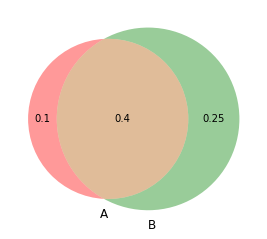

In [144]:
P = Probability()
R = Event('Red')
TestR = Event('Senses Red')
#sensitivity is 0.8
P[TestR|R] = 0.8
#But specificity is 0.5
P[~TestR|~R] = 0.5
#And this is back to a uniform distribution
#No need to use the second P[R] = P[~R]; TODO: 
#1) P should detect inconsistencies if user passes new values but there is existing value
#Or would infer new values that contradict existing values
# 2) ability to turn off the error checking, and just "100% push out the wrinkles" in every direction after each new value is set.
#
#TypeError: 'Event' object is not iterable

P[R] = 0.5

#And I am moving this assignment P[R] = ..., *after* the above assignments, to test that my P class can go all the directions
#It needs to go!
print(P[R| TestR])
print(P[~R| TestR])
P.venn(R, TestR)

0.9876543209876543
0.012345679012345734


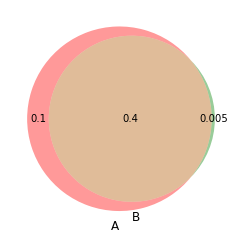

In [146]:
P = Probability()
R = Event('Red')
TestR = Event('Senses Red')
#sensitivity is 0.8
P[TestR|R] = 0.8
#But specificity is 0.5
P[~TestR|~R] = 0.99
#And this is back to a uniform distribution
#No need to use the second P[R] = P[~R]; TODO: 
#1) P should detect inconsistencies if user passes new values but there is existing value
#Or would infer new values that contradict existing values
# 2) ability to turn off the error checking, and just "100% push out the wrinkles" in every direction after each new value is set.
#
#TypeError: 'Event' object is not iterable

P[R] = 0.5

#And I am moving this assignment P[R] = ..., *after* the above assignments, to test that my P class can go all the directions
#It needs to go!
print(P[R| TestR])
print(P[~R| TestR])
P.venn(R, TestR)

In [151]:
P = Probability()
A = Event('A - Red')
B = Event('B - Green')
C = Event('C - Green')
P[A] = P[B] = P[C] = (1/3.)
TestR = Event('Test Red')
#WHOA this works even though I now have multiple possible events; 3 events (A, B, C), 
#However, those events are reduced to the thing-being-tested-for : are you Red or ~Red ? 
#And the representation in this case, is pretty poor... I just append "A - Red" , or "B - Green"...
P[TestR | A] = P[TestR | B] = P[TestR | C] = 0.9
print(P(A & TestR))
#Ah, so it doesnt work, because it I really do need to be using the P(G), which I dont calculate anywhere
#I could start using sets, this is where the venn diagram excels;
#So I say Event('Red', set('A'))
#And then Event(~Red, set('B', 'C'))
#And then only know the Event('Red') = 1/3, and the Event (~Red) = 2/3, because we have their full sets ? 
#that strongly associates the sets with the Event, which I thought we were trying to keep the probabilities associated with each intsance of P
#P(Red) = set('A', 'C')
#What if there is overlap!
print(P(B & TestR))
print(P(C & TestR))

0.3
0.3
0.3


In [153]:
# I dont like in Robot Sending 5 how P(R|A) is used; the "R" is ambiguous; 
# is it "see R" or "is R"? I think it must be "see R"


In [155]:
s=set('AB')

In [156]:
isinstance(s,set)

True

In [189]:
P = Probability()
Red = Event('Red')
P[Red] = set('A')
P[~Red] = set('BC')

#We wont actually represent their probabilities directly
#they are only relevant insofar as they help us infer probability of Red
#P[A] = P[B] = P[C] = (1/3.)
TestR = Event('Test Red')
P[TestR | Red] = 0.9
P[~TestR | ~Red] = 0.9
print(P(Red & TestR))
#Divide by two because the Probability is equality distributed between them
print(P(~Red & TestR) /2)
print(P.__event_set_map__)
print(P('A'))
print(P('B'))
print(P(~Event('B')))

0.30000000000000004
0.033333333333333326
{Event("Red"): {'A'}, Event("not(Red)"): {'B', 'C'}}
0.3333333333333333
0.3333333333333333
0.6666666666666667


In [175]:

type(Event('Red'))

__main__.Event

In [168]:
prob_r_giv_b =1- 0.9
prob_b = 1./3.
prob_r_and_b = prob_r_giv_b*prob_b
print(prob_r_and_b)

0.033333333333333326


In [194]:
#alright trying it again
#Robot Sensing 6:
P = Probability()
A = Event('A')
B = Event('B')
C = Event('C')
#Can skip this for now, am inferring from the fact that they are in teh set
# P[A] = P[B] = P[C] = (1/3.)
Red = Event('Red')
P[Red] = {A}
P[~Red] = {B, C}
TestR = Event('Test Red')
print(P(A))
#WHOA this works even though I now have multiple possible events; 3 events (A, B, C), 
#However, those events are reduced to the thing-being-tested-for : are you Red or ~Red ? 
#And the representation in this case, is pretty poor... I just append "A - Red" , or "B - Green"...
P[TestR | A] = P[~TestR | B] = P[~TestR | C] = 0.9
print(P(A & TestR))
#Ah, so it doesnt work, because it I really do need to be using the P(G), which I dont calculate anywhere
#I could start using sets, this is where the venn diagram excels;
#So I say Event('Red', set('A'))
#And then Event(~Red, set('B', 'C'))
#And then only know the Event('Red') = 1/3, and the Event (~Red) = 2/3, because we have their full sets ? 
#that strongly associates the sets with the Event, which I thought we were trying to keep the probabilities associated with each intsance of P
#P(Red) = set('A', 'C')
#What if there is overlap!
print(P(B & TestR))
print(P(C & TestR))

0.3333333333333333
0.3
0.033333333333333326
0.033333333333333326


In [212]:
#alright trying it again
#Robot Sensing 6:
P = Probability()
A = Event('A')
B = Event('B')
C = Event('C')
#WHOA I can just *tell it*, and it will work !
#P[A] = 1/2.; P[B] = P[C] = (1/3.);
Red = Event('Red')
P[Red] = {A}
P[~Red] = {B, C}
TestR = Event('Test Red')
print(P(A))
#WHOA this works even though I now have multiple possible events; 3 events (A, B, C), 
#However, those events are reduced to the thing-being-tested-for : are you Red or ~Red ? 
#And the representation in this case, is pretty poor... I just append "A - Red" , or "B - Green"...
P[TestR | A] = P[~TestR | B] = P[~TestR | C] = 0.9
print(P(A & TestR))
#Ah, so it doesnt work, because it I really do need to be using the P(G), which I dont calculate anywhere
#I could start using sets, this is where the venn diagram excels;
#So I say Event('Red', set('A'))
#And then Event(~Red, set('B', 'C'))
#And then only know the Event('Red') = 1/3, and the Event (~Red) = 2/3, because we have their full sets ? 
#that strongly associates the sets with the Event, which I thought we were trying to keep the probabilities associated with each intsance of P
#P(Red) = set('A', 'C')
#What if there is overlap!
print(P(B & TestR))
print(P(C & TestR))

#Darn , don't know it yet, even though can infer it...
print(P.get(TestR))
#That would require , either 
#1------------
#Figuring the Red & TestR vs ~Red & TestR (not done, easy to imagine now because B and C are equally good specificity. But even if we merge denominators, we merge numerators, we just divide again. Problem is, while we dont know  separate, denominators, thats what we are trying to find, we know union of denominators!)
    #This is i still hard, requires we have the entire set of elements for a given Event, like all the red subsevents (A), and all green subevents (B, C)
    #But we do have those in a map...
# adding these two  to get TestR (done)
#P(TestR | R) * P(R) + P(~TestR | ~R) * P(~R)
print(0.9 * (1./3.) + 0.1 * (2./3.))
    #The P(~TestR | ~R) is 0.1 because :
    #Normalizing over their repsective sections of green:
    #Practically 0.1...
print(((1-0.9) *  1./3. + (1-0.9)   * 1./3.)/(2./3.))
#2------------
#inferring which joints are part of the same "Event domain" (not done, hard, means events must be domained!) or else we can only know this when we know we have that total_set ? 
#adding all of them, however many there are:  the A & TestR + B & TestR + C & TestR (not done, hopefully easy, can replace "add two" with "add all events of same domain")
#P(A&TestR)

#and 
print(0.9 * (1./3.) + 0.1 * (1./3.) + 0.1 * (1./3.))

0.3333333333333333
0.3
0.033333333333333326
0.033333333333333326
None
0.36666666666666664
0.09999999999999998
0.36666666666666664


In [199]:
P[TestR]

KeyError: Event("Test Red")

In [211]:
print(0.3/0.366)
print(0.033/0.366)
print(0.033/0.366)

0.819672131147541
0.09016393442622951
0.09016393442622951


0.021739130434782608


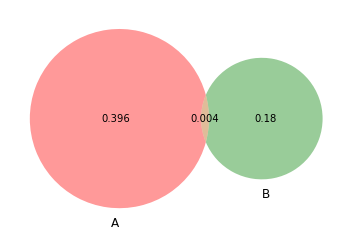

In [215]:
P = Probability()
home = Event('home')
rain = Event('rain')
P[~home] = 0.6
#Duh! P[home]

P[rain | home] = 0.01
#Can calculate the "specificity" using this...
P[rain | ~home] = 0.3

print(P[home| rain])

P.venn(home, rain)


In [217]:
def flip_one_of_two():
    #prob you pick coin 1
    p0 = 0.3
    #prob you flip heads given coin 1
    p1 = 0.5
    #prob you flip heads given coin 2
    p2 = 0.9
    #p(h | 1)
    #p(h | 2)
    #since 1 and 2 are mutually exclusive and together represent the unity (i.e. 1, the only possibilities)
    ph = p0 * p1 + (1-p0) * p2
    return ph
flip_one_of_two()
    

0.78

In [229]:
def cancer_example_1():
    p0 = 0.1 #p_c
    p1 = 0.9 #p_pos_giv_c
    p2 = 0.8 #p_neg_giv_notc
    
    p_c=p0
    p_pos_giv_c = p1
    p_neg_giv_notc = p2
    
    #... Same formula. This is what he was doing. Trickery! Haha. Effective... 
    #Oh, not quite, note we must subtract the second number from 1 first, (turning the specificity into something else...)
    p_pos = p0 * p1 + (1- p0) * (1-p2)
    return p_pos
    
print(cancer_example_1())
assert np.isclose(cancer_example_1(),0.270), 'cancer normalizer (i.e. probability test is positive) should be\
sum of p(c) * p(pos|c) + p(~c) * p(pos|~c), which is 0.2670 in this case'

0.26999999999999996


In [223]:
P=Probability()
P['C'] = 0.1
P[Event('Pos') | Event('C')] = 0.9
P[~Event('Pos') | ~Event('C')] = 0.8
print(P['Pos'])

0.26999999999999996


In [230]:
P=Probability()
P['C'] = 0.1
P[Event('Pos') | Event('C')] = 0.9
P[~Event('Pos') | ~Event('C')] = 0.8
print(P['Pos'])
print(P[Event('C') | Event('Pos')])

0.26999999999999996
0.3333333333333334


In [231]:
0.1 * 0.9 / 0.270

0.33333333333333337

In [235]:
def cancer_example_2():
    p0 = 0.1 #p_c
    p1 = 0.9 #p_pos_giv_c
    p2 = 0.8 #p_neg_giv_notc
    
    p_c=p0
    p_pos_giv_c = p1
    p_neg_giv_notc = p2
    
    #... Same formula. This is what he was doing. Trickery! Haha. Effective... 
    #Oh, not quite, note we must subtract the second number from 1 first, (turning the specificity into something else...)
    p_pos = p0 * p1 / (p0 * p1 + (1- p0) * (1-p2))
    return p_pos
    
print(cancer_example_2())
assert np.isclose(cancer_example_2(),0.333333), 'cancer normalizer (i.e. probability have cancer given test is positive) should be\
(p(c) * p(pos|c)  / ( sum of p(c) * p(pos|c) + p(~c) * p(pos|~c)), which is 0.33 in this case'

0.3333333333333334


In [241]:
def program_bayes_rule_2():
    p0 = 0.1 #p_c
    p1 = 0.9 #p_pos_giv_c
    p2 = 0.8 #p_neg_giv_notc
    
    p_c=p0
    p_pos_giv_c = p1
    p_neg_giv_notc = p2
    
    #... Same formula. This is what he was doing. Trickery! Haha. Effective... 
    #Oh, not quite, note we must subtract the second number from 1 first, (turning the specificity into something else...)
    p_pos = (p0 * p1 + (1- p0) * (1-p2))
    
    p_neg = 1-p_pos
    #p_not_c_giv_neg = p_neg_giv_notc * (1-p_c)/(1-p_pos)
    #p a conditioned on not b
    
    #There is another way to do it, this is how Sebastian does it:
    p_neg = p0 * (1-p1) + (1-p0) * p2
    p_c_giv_neg = p_c * (1-p_pos_giv_c) / p_neg # (1-p_pos)
    
    #     return p_not_c_giv_neg
    return p_c_giv_neg

print(program_bayes_rule_2())
assert np.isclose(program_bayes_rule_2(),0.01369863013), 'cancer normalizer (i.e. probability have cancer given test is negative) should be\
(p(c) * (1-p(pos|c))  / (1-( sum of p(c) * p(pos|c) + p(~c) * p(pos|~c))), which is 0.01369863013 in this case'

0.013698630136986297


In [242]:
(290-260)/360.

0.08333333333333333

In [243]:
1/360.

0.002777777777777778

In [244]:
1/60.

0.016666666666666666

In [245]:
1/24

0.041666666666666664

In [246]:
(1/24) * (2/3)

0.027777777777777776

In [247]:
(1/24) * (2/3) * 2

0.05555555555555555

In [251]:
# Just consider that the *area* must be one-third. Can think in terms of unity
#And since the *width* is 12 hrs, then the height must be... (area divided by width) 
1/3. / 12

0.027777777777777776

In [252]:
#4 'probability units' (?)
2/3. / 12

0.05555555555555555

36